In [1]:
# とりあえず見えないように
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 使用するライブラリのインポート
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
from rpy2.robjects import r, pandas2ri
import matplotlib.pyplot as plt

# 回帰分析
## 回帰分析とは
### 会期の由来
### システム論から見た回帰分析
回帰モデルを求めるとは、説明変数をシステム(物理現象や社会・経済現象により、数学モデルで近似する)に入力し、回帰モデルを求める。(誤差のノルムを何らかの方法で測り、最小化を図る)  
回帰モデルを求めるとは、パラメータを求めることを意味する。  

**回帰分析の流れ**
1. (モデル構造が既知と仮定して、)モデル次数pを選定する
2. x, yを用いて、偏回帰係数βを推定し、回帰モデルを求める
3. この回帰モデルを用いて、目的変数が未知で新たな説明変数をモデルに入力して、目的変数を予測する  

### statsmodels
本章では、回帰モデルのパラメータ推定にOLS法(ordinary least squares)を扱う。

## 単回帰分析
### 単回帰分析の意義
- 計測データは離散値となる。このため、隣り合うデータの間のyを知りたい場合に、この値を予測することができる。
- サンプルの区間を超えた目的変数の値を予測することができる。
- バイパスパラメータ(切片)と傾きを見ることで、説明変数に基づく目的変数の発生メカニズム推定の手がかりを得る。

### 単回帰モデルの統計的評価
**偏回帰係数のt検定**  
係数が0か否かを検定する。  

**決定係数**  
決定係数はR^2で表され、回帰モデルのデータに対するあてはまりの良さを表す指標である。  
0 < R^2 <= 1  
1に近いほどよい当てはまりとされる。一般的に0.6以下ならば良くないが、0.8以上ならばある程度良いモデルであるとされている。

### 家計調査
家計調査のWebサイトから、2人以上世帯の年間収入に対して、1ヶ月あたりの支出とエンゲル係数のそれぞれに対する単回帰分析を行う。


In [3]:
import statsmodels.formula.api as smf
import pandas as pd

url = 'https://sites.google.com/site/datasciencehiro/datasets/FamilyIncome.csv'
df = pd.read_csv(url, comment='#')
print(df)

   income  expenditure  engel
0     216       172462   30.8
1     304       204599   29.9
2     356       224776   28.8
3     413       240153   27.8
4     481       255497   27.3
5     555       275490   25.9
6     642       295447   25.7
7     752       323072   24.7
8     902       362769   23.4
9    1461       467616   21.8


incomeは年間収入、expenditureは1ヶ月支出、engelはエンゲル係数の並びである。  
説明変数をincome、目的変数をexpenditureとした単回帰分析は以下のように記述する。

In [4]:
result = smf.ols('expenditure ~ income', data=df).fit()
print(result.summary())
b0, b1 = result.params # b0に切片、b1に傾き

                            OLS Regression Results                            
Dep. Variable:            expenditure   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     624.7
Date:                   土, 29  2 2020   Prob (F-statistic):           7.02e-09
Time:                        06:09:06   Log-Likelihood:                -105.43
No. Observations:                  10   AIC:                             214.9
Df Residuals:                       8   BIC:                             215.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     1.4e+05   6550.516     21.366      0.0

この結果より、求めた単回帰モデルは以下となる。  
`expenditure = b0 + b1 * income`  

**単回帰モデルを用いた予測**  
サンプルデータにない家庭の収入を求めてみる

In [5]:
NewData = {'income' : [1100, 1200]}
df2 = pd.DataFrame(NewData)
pred = result.predict(df2)
pred

0    397198.498402
1    420584.101981
dtype: float64

上の場合は、0が年収1100万の家庭の1ヶ月の支出になる。  

次に、目的変数をengel、説明変数をincomeとしたときを分析してみる。

In [6]:
result = smf.ols('engel ~ income', data=df).fit()
print(result.summary())
b0, b1 = result.params # b0に切片、b1に傾き

                            OLS Regression Results                            
Dep. Variable:                  engel   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     59.88
Date:                   土, 29  2 2020   Prob (F-statistic):           5.54e-05
Time:                        06:09:06   Log-Likelihood:                -13.470
No. Observations:                  10   AIC:                             30.94
Df Residuals:                       8   BIC:                             31.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.0757      0.664     46.781      0.0

### シンプソンのパラドックス
回帰分析を直ちに行うのではなく、その前にデータの可視化も含めていくつかの統計的特徴量を見てから、回帰分析を実施し、この事前分析と照合して結果を評価することが望ましい。

### 数学的説明
省略  

## 多項式回帰分析
多項式をモデルに用いる。ただし、ここでは説明変数は1種類であるとする  

### 多項式モデル
観測データが2次式や3次式のグラフに近い分布を示しているとき、単回帰モデルより、多項式モデルを用いたフィッティングのほうが好ましいという考え方がある  

### Rデータセットのcars
Rのデータセットの中にあるcarsには、車がブレーキを掛けたときの停止距離[ft]と速度[mile/h]との測定データがある。これを例に多項式回帰分析を行う。


In [7]:
import statsmodels.formula.api as smf
from rpy2.robjects import r, pandas2ri

pandas2ri.activate()
df = r['cars'] # carsのデータセットを読み込む
x = df.speed
print(df.head())


   speed  dist
1    4.0   2.0
2    4.0  10.0
3    7.0   4.0
4    7.0  22.0
5    8.0  16.0


In [8]:
# 2次
result2 = smf.ols('dist ~ np.power(speed,2) + speed', data=df).fit()

# 3次
result3 = smf.ols('dist ~ np.power(speed,3) + np.power(speed,2) + speed', data=df).fit()


In [9]:
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     47.14
Date:                   土, 29  2 2020   Prob (F-statistic):           5.85e-12
Time:                        06:09:06   Log-Likelihood:                -205.39
No. Observations:                  50   AIC:                             416.8
Df Residuals:                      47   BIC:                             422.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.4701     14

In [10]:
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     31.58
Date:                   土, 29  2 2020   Prob (F-statistic):           3.07e-11
Time:                        06:09:06   Log-Likelihood:                -204.94
No. Observations:                  50   AIC:                             417.9
Df Residuals:                      46   BIC:                             425.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -19.5050     28

## 重回帰分析
p次の回帰モデル(p>=2)を用い、説明変数が複数あるもの。単回帰モデルとは異なる見方がある。  
複数の偏回帰係数がゼロであるか否かを一括して考えるF検定、および説明変数間に強い相関がある場合の多重共線性である。  
これらの説明のため、人口データを用いたシミュレーションを行う。

### F検定

In [11]:
num = 30
noise = np.random.normal(0.0, 0.1, num)
rad = np.linspace(-np.pi, np.pi, num)
x1 = np.sin(rad)
x2 = np.random.normal(-2.0, 3.0, num)

In [12]:
b1, b2 = 1.1, -0.55
y = b1*x1 + b2*x2 + noise
df = pd.DataFrame({'y':y, 'x1':x1, 'x2':x2})
results = smf.ols('y ~ x1 + x2 -1', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.345e+04
Date:                   土, 29  2 2020   Prob (F-statistic):                    1.73e-42
Time:                        06:09:06   Log-Likelihood:                          33.517
No. Observations:                  30   AIC:                                     -63.03
Df Residuals:                      28   BIC:                                     -60.23
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1379      0.022     52.382      0.000       1.093       1.182
x2            -0.5497      0.004   -146.835      0.000      -0.557      -0.542
==============================================================================
Omnibus:                        4.050   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                1.637
Skew:                          -0.120   Prob(JB):                        0.441
Kurtosis:                       1.881   Cond. No.                         5.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

これにおいて、F-statisticはF値を、Prob(F-statistics)はその確率を表している  
またt検定では、両方の係数ともにゼロではないことを示している  

### 多重共線性
説明変数同士に高い相関がある場合に生じる現象

In [13]:
num = 30
rad = np.linspace(-np.pi, np.pi, num)
x1 = np.sin(rad)
x2 = np.random.normal(-2.0, 3.0, num)

b1, b2 = 3.3, -1.25
noise = 0.001*np.random.normal(0.0, 1.0, num)
y = b1*x1 + b2*x2 + noise

In [14]:
x3 = 3.35*np.sin((rad+0.001)) + 0.001*np.random.normal(0.0, 0.1, num)
df = pd.DataFrame({'y':y, 'x1':x1, 'x2':x2, 'x3':x3})
results = smf.ols('y ~ x1 + x2 + x3 -1', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.738e+08
Date:                   土, 29  2 2020   Prob (F-statistic):                   4.03e-101
Time:                        06:09:06   Log-Likelihood:                          170.95
No. Observations:                  30   AIC:                                     -335.9
Df Residuals:                      27   BIC:                                     -331.7
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.3068      0.218     15.201      0.000       2.860       3.753
x2            -1.2500    4.7e-05  -2.66e+04      0.000      -1.250      -1.250
x3            -0.0021      0.065     -0.032      0.975      -0.135       0.131
==============================================================================
Omnibus:                        0.489   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.783   Jarque-Bera (JB):                0.357
Skew:                           0.251   Prob(JB):                        0.836
Kurtosis:                       2.818   Cond. No.                     4.94e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 電力と気温の関係
消費電力が最高気温と最低気温との間にどのような関係にするか重回帰分析を用いて考察する

In [15]:
# 電力使用量データの読み込み
url = 'https://sites.google.com/site/datasciencehiro/datasets/ElectricPower.csv'
df_pow = pd.read_csv(url, comment='#', index_col='DATE', parse_dates=['DATE'], encoding='SHIFT-JIS')
df_pow2 = df_pow.resample('D').max()
df_pow.head()

,TIME,Power
DATE,,
2017-01-01,0:00,2783
2017-01-01,1:00,2634
2017-01-01,2:00,2520
2017-01-01,3:00,2438
2017-01-01,4:00,2389


In [16]:
# 気象データの読み込み
url = 'https://sites.google.com/site/datasciencehiro/datasets/AirTemperature.csv'
df = pd.read_csv(url, comment='#', index_col='Date', parse_dates=['Date'], encoding='SHIFT-JIS')
df['MaxPower'] = df_pow2.Power

In [17]:
result = smf.ols('MaxPower ~ MaxTemp + MinTemp', data=df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               MaxPower   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3421
Date:                   土, 29  2 2020   Prob (F-statistic):              0.711
Time:                        06:09:11   Log-Likelihood:                -2799.2
No. Observations:                 365   AIC:                             5604.
Df Residuals:                     362   BIC:                             5616.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3919.7384    104.068     37.665      0.000    3715.085    4124.392
MaxTemp       -3.9502      9.762     -0.405      0.686     -23.147      15.246
MinTemp        1.1954      9.427      0.127      0.899     -17.343      19.734
==============================================================================
Omnibus:                       10.037   Durbin-Watson:                   0.472
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.221
Skew:                           0.385   Prob(JB):                      0.00603
Kurtosis:                       2.718   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

これより、全般的に良くない結果であることがわかる  

次に、期間を区切った分析を行う

In [18]:
df1 = df['2017/1/15':'2017/4/30']
df2 = df['2017/5/1':'2017/8/31']

In [19]:
result1 = smf.ols('MaxPower ~ MaxTemp + MinTemp', data=df1).fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:               MaxPower   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     124.4
Date:                   土, 29  2 2020   Prob (F-statistic):           3.41e-28
Time:                        06:09:11   Log-Likelihood:                -738.60
No. Observations:                 106   AIC:                             1483.
Df Residuals:                     103   BIC:                             1491.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4831.8773     89.797     53.809      0.0

In [20]:
result2 = smf.ols('MaxPower ~ MaxTemp + MinTemp', data=df2).fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:               MaxPower   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     136.5
Date:                   土, 29  2 2020   Prob (F-statistic):           1.22e-31
Time:                        06:09:11   Log-Likelihood:                -896.64
No. Observations:                 123   AIC:                             1799.
Df Residuals:                     120   BIC:                             1808.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    400.5727    232.395      1.724      0.0

In [21]:
NewData = {'MaxTemp':[18.5,14.0], 'MinTemp':[9.0,6.5]}
NewDf = pd.DataFrame(NewData)
pred = result.predict(NewDf)
pred

0    3857.418964
1    3872.206192
dtype: float64

### ワインの品質分析
ワインの様々な成分の値から、その品質の推定を行う  
ワインごとに測定された11種類の成分データとそのワインの味を評価したグレードは3人以上のワイン査定士が評価した結果の平均値であり、これはquality(0(まずい)~10(絶品))として表現される


In [22]:
url = 'https://sites.google.com/site/datasciencehiro/datasets/winequality-red_mod.csv'
wine_set = pd.read_csv(url, sep=';')
wine_set.head(6)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


In [23]:
ols_model = "quality ~ volatile_acidity + chlorides + total_sulfur_dioxide + sulphates + alcohol" # 重回帰分析の目的変数と説明変数の設定
results = smf.ols(formula=ols_model, data=wine_set).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     172.7
Date:                   土, 29  2 2020   Prob (F-statistic):          5.48e-147
Time:                        06:09:13   Log-Likelihood:                -1580.4
No. Observations:                1599   AIC:                             3173.
Df Residuals:                    1593   BIC:                             3205.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.0049      0.204     14.747      0.000       2.605       3.405
volatile_acidity        -1.1419      0.097    -11.779      0.000      -1.332      -0.952
chlorides               -1.7048      0.392     -4.352      0.000      -2.473      -0.937
total_sulfur_dioxide    -0.0023      0.001     -4.544      0.000      -0.003      -0.001
sulphates                0.9148      0.110      8.296      0.000       0.699       1.131
alcohol                  0.2771      0.016     16.811      0.000       0.245       0.309
==============================================================================
Omnibus:                       25.233   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.739
Skew:                          -0.153   Prob(JB):                     6.38e-09
Kurtosis:                       3.688   Cond. No.                     1.40e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 一般化線形モデル
### 一般化線形モデルの概要
GLMとして離散確率変数を対象としたポアソン回帰モデルとロジスティック回帰モデルについて  
これまでは、目的変数をy、説明変数をxとおいており、これは変わらない  
GLMではyを予測するのではなく、yが従う確率分布のパラメータを予測する

### ポアソン回帰モデル
目的変数yは0から始まる計数データとする  
関数式などは省略する  

### z = β<sub>0</sub>のとき
ポアソン回帰モデルを用いたシミュレーションを通して、何を求めるかを見てみる。  
ポアソン分布の平均値λをスクリプト中でlamとし、ポアソン分布に従う目的変数(y)をNum個発生させ、そのヒストグラムと最所のn点のプロットを行う。

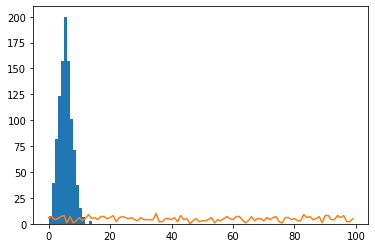

In [24]:
%matplotlib inline
Num = 1000
lam = 5
y = np.random.poisson(lam,Num)

count, bins, ignored = plt.hist(y, 14, density=False)
n = 100
plt.plot(y[0:n])

このデータを用いて一般線形化モデルを解くのが次である。

In [25]:
x = range(len(y))
df = pd.DataFrame({'x': x, 'y': y})
glm_model = 'y ~ x'
result = smf.glm(formula=glm_model, data=df, family=sm.families.Poisson(link=sm.families.links.log)).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2198.9
Date:                   土, 29  2 2020   Deviance:                       1034.7
Time:                        06:09:13   Pearson chi2:                     964.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6283      0.028     57.935      0.000       1.573       1.683
x           -3.11e-05   4.89e-05     -0.636      0.525      -0.000    6.48e-05
==============================================================================
"""

引数family(族)は、用いる確率分布を指定し、linkはリンク関数を指定する。  
この結果より、xの計数(coef)は、ほぼ0とみなせる。Interseptはβ<sub>0</sub>のことである。  
この値に対して、次の計算を行う。

In [26]:
b0, b1 = result.params
print('exp(b0) = ', np.exp(b0))
print('Mean of y = ', df.y.mean())

exp(b0) =  5.095341489147122
Mean of y =  5.017


上の出力の1行目は、λ = exp(β<sub>0</sub>)の計算を示しており、2行目はyの標本平均を計算している。
データ発生時に与えたポアソン分布の平均値lamと比較して、両者とも近い値を示している。

### z = β<sub>0</sub> +  β<sub>1</sub> x<sub>1</sub>の例

この場合のポアソン回帰モデルを用いたシミュレーションは工夫がいる。なぜならば、平均値λ=exp(z)が変化するためである。

In [27]:
Num = 1000
x = np.zeros(Num)
y = np.zeros(Num)
b0, b1 = 0.5, 3.5
for i in range(Num) :
    x[i] = i
    lam = np.exp(b0+(b1/float(Num)) * (float(i)))
    y[i] = np.random.poisson(lam, 1)

このデータに対する回帰分析を次のように行う。

In [28]:
df = pd.DataFrame({'x': x, 'y': y})
glm_model = 'y ~ x'
result = smf.glm(formula=glm_model, data=df, family=sm.families.Poisson(link=sm.families.links.log)).fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2493.4
Date:                   土, 29  2 2020   Deviance:                       994.03
Time:                        06:09:13   Pearson chi2:                     962.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4626      0.029     16.065      0.0

この結果を見て、2つの係数はどちらも0とは言えないので、これらを変換する計算と結果を次に示す。

In [29]:
b0, b1 = result.params
b1 = b1 * Num
print("b0 = %f b1 = %f" % (b0, b1))

b0 = 0.462594 b1 = 3.529948


この結果と真のb0, b1の値を比べて、近い値が得られていることが認められる。  
この値を用いて、λ<sub>i</sub>がどのように変化したかを図示する。

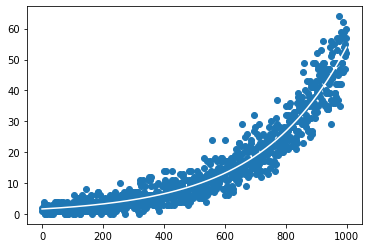

In [30]:
y_pre = np.exp(b0 + (b1/float(Num))*x)
plt.scatter(x[0:Num], y[0:Num])
plt.plot(x, y_pre, color='white')

この図ではyの集合平均が白線でよく表されているというのが正しい表現である。  
すなわち、ポアソン回帰モデルはλ<sub>i</sub>を推定していることがわかる。  
上記のデータをシャッフルして、回帰分析をした結果は同じである。このときのプロットは、見た目的には右肩上がりではないが、ポアソン回帰モデルが適用できる。ポアソン分布に従うデータであるならば、ポアソン回帰モデルが適用できることを意味する。  
これより、データを見ただけで適用できるかどうか判断することは難しいため、データの物理的背景から推測することが多い。

### ロジスティック回帰モデル
ロジスティック回帰モデルを用いた回帰分析では、目的変数yが0,1の2値をとるデータによく適用される。

#### ロジスティック関数の導入
ロジスティック回帰モデルの目的は、確率pを説明変数から推定できるモデルを得ることにある。

#### カブトムシ問題
薬品の投薬量とカブトムシの生存率を取り上げる。  
データは、n:薬品を与えたカブトムシの数、x:薬品の投薬量、y:そのうち死んだ数  
死亡(y)と生存(n-y)で表されるような場合のスクリプトは次のようになる。

In [31]:
df = pd.DataFrame({'x':[1.6907, 1.7242, 1.7552, 1.7842, 1.8113, 1.8369, 1.861, 1.8839],
                   'n':[59, 60, 62, 56, 63, 59, 62, 60],
                   'y':[ 6, 13, 18, 28, 52, 53, 61, 60]})

glm_model = 'y + I(n-y) ~ x'
result = smf.glm(formula=glm_model, data=df, family=sm.families.Binomial(link=sm.families.links.logit)).fit()
print(result.summary())

b0, b1 = result.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:      ['y', 'I(n - y)']   No. Observations:                    8
Model:                            GLM   Df Residuals:                        6
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18.715
Date:                   土, 29  2 2020   Deviance:                       11.232
Time:                        06:09:13   Pearson chi2:                     10.0
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -60.7175      5.181    -11.720      0.0

#### 成績アップの分析

In [32]:
data = sm.datasets.spector.load().data
df = pd.DataFrame(data)
df.head()

,GPA,TUCE,PSI,GRADE
0,2.66,20.0,0.0,0.0
1,2.89,22.0,0.0,0.0
2,3.28,24.0,0.0,0.0
3,2.92,12.0,0.0,0.0
4,4.00,21.0,0.0,1.0


これはPSIという教育プログラムを受けたら、成績が上がるかどうかを検証したデータである。  
データはそれぞれ、GPA:成績、TUCE:テストの結果、PSI:ある教育プログラムを受けたかどうか、GRADE:成績が上がったかどうか、である。  
目的変数をGRADEとして、PSIの受講が成績上昇に寄与したかどうかを調べるため、ほかの要因も説明変数として与える。  
GRADEが2値変数であるため、ロジスティック回帰モデルを用いた回帰分析を行う。

In [33]:
glm_model = 'GRADE ~ GPA + TUCE + PSI'
fit = smf.glm(formula=glm_model, data=df, family=sm.families.Binomial(link=sm.families.links.logit))
result = fit.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  GRADE   No. Observations:                   32
Model:                            GLM   Df Residuals:                       28
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12.890
Date:                   土, 29  2 2020   Deviance:                       25.779
Time:                        06:09:13   Pearson chi2:                     27.3
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.0213      4.931     -2.641      0.0

この結果より、TUCEの計数は他2つより低いので、影響は小さいと言える。  
次にPSIとGPAを比べた場合、若干ではあるが、GPAの方がPSIよりGRADEへの影響が大きいと言える。(これだけでは判断しにくいが)

### 数学的説明